<ipython-input-1-f8a2b128f5c8>:84: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim), origin='lower')


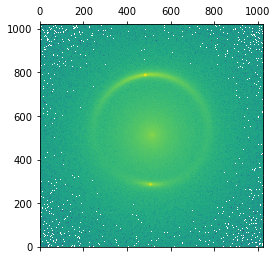

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
#%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# data specifics
background_rms = 0.      # background noise per pixel
exp_time       = 1200    # exposure time (arbitrary
                         # units, flux per pixel is in units
                         # photons/exp_time unit)
numPix         = 1024    # cutout pixel size [Image = numPix X numPix]
deltaPix       = 1./256  # pixel size in arcsec
                         # (area per pixel = deltaPix**2)
fwhm           = 0.025   # full width half max of PSF (arc sec?)

# PSF specification
kwargs_data    = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class     = ImageData(**kwargs_data)
kwargs_psf     = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class      = PSF(**kwargs_psf)

lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': -0.1}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 2.96, 'center_x': 0, 'center_y': 0, 'e1': 0., 'e2': 0.}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 1000, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# 'SERSIC_ELLIPSE': elliptical Sersic profile

source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.2
kwargs_sersic_ellipse = {'amp': 4000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.1}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

In [2]:
print(x_image[0],y_image[0],mag[0],mag[1])

-0.11970773071753268 1.074772225865053 5.946088921347462 1.393400124558448


In [8]:
def caustic_finder(mag_0,mag_1):
    if mag_0>mag_1:
        index = 1
    else:
        index = 0
    print(index)

In [11]:
caustic_finder(mag[0],mag[1])
index=1

1


<ipython-input-19-023615857ee5>:32: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim), origin='lower')


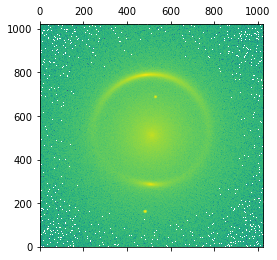

x_image[0]: -0.1219457259485612 y_image[0]: -1.364657949642571
x_image[1]: 0.06302475519200319 y_image[1]: 0.6824575375643824
mag[0]: 1.6173471800672286 mag[1]: 0.31402583241223325
1


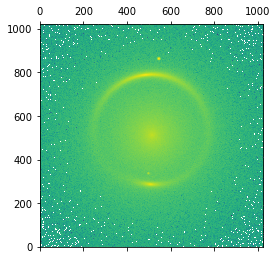

x_image[0]: 0.12329478480396039 y_image[0]: 1.3645349303758967
x_image[1]: -0.0635155471273013 y_image[1]: -0.6824118438178033
mag[0]: 1.6173570132194783 mag[1]: 0.3140250005756021
1


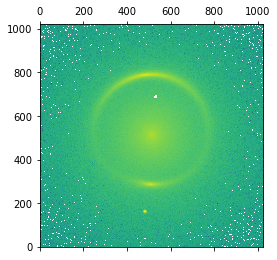

x_image[0]: -0.12452113119113926 y_image[0]: -1.3644220823506346
x_image[1]: 0.06396169820293654 y_image[1]: 0.6823700130783009
mag[0]: 1.617365140227608 mag[1]: 0.31402431311597223
1


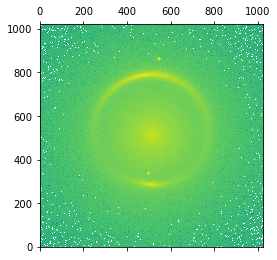

x_image[0]: 0.12563593072497958 y_image[0]: 1.364318656793167
x_image[1]: -0.06436727030163916 y_image[1]: -0.6823317446907904
mag[0]: 1.6173718570293116 mag[1]: 0.3140237449615382
1


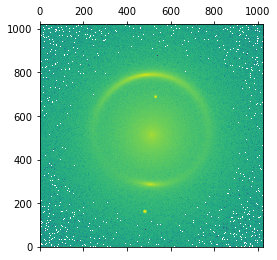

x_image[0]: -0.12664933286300067 y_image[0]: -1.364223942406885
x_image[1]: 0.06473595553037659 y_image[1]: 0.6822967565647741
mag[0]: 1.617377408304346 mag[1]: 0.31402327541494973
1


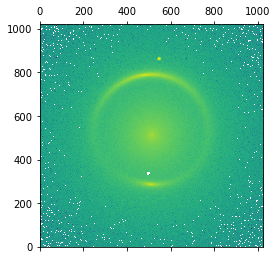

x_image[0]: 0.1275705632498624 y_image[0]: 1.3641372673315186
x_image[1]: -0.06507110989532246 y_image[1]: -0.6822647849960444
mag[0]: 1.6173819962552223 mag[1]: 0.31402288736094713
1


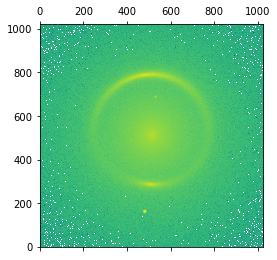

x_image[0]: -0.12840800786100992 y_image[0]: -1.3640579999112856
x_image[1]: 0.0653757839142754 y_image[1]: 0.6822355842616539
mag[0]: 1.6173857880332485 mag[1]: 0.3140225666570242
1


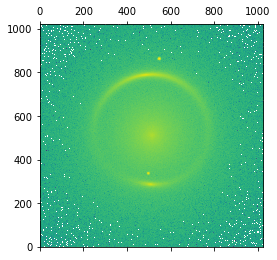

x_image[0]: 0.12916928938559732 y_image[0]: 1.363985548681654
x_image[1]: -0.06565275044086809 y_image[1]: -0.6822089260247414
mag[0]: 1.6173889217897262 mag[1]: 0.3140223016137797
1


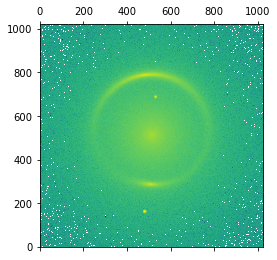

x_image[0]: -0.1298613367217462 y_image[0]: -1.3639193617082574
x_image[1]: 0.06590452995446366 y_image[1]: 0.6821845986150736
mag[0]: 1.6173915117090838 mag[1]: 0.31402208257077624
1


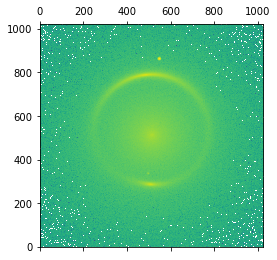

x_image[0]: 0.1304904481432717 y_image[0]: 1.3638589254684517
x_image[1]: -0.06613341347955937 y_image[1]: -0.682162406203119
mag[0]: 1.6173936521643806 mag[1]: 0.3140219014838391
1


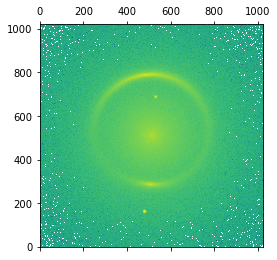

x_image[0]: -0.1310623486240558 y_image[0]: -1.363803763381598
x_image[1]: 0.06634148358477772 y_image[1]: 0.6821421680456144
mag[0]: 1.6173954212271555 mag[1]: 0.31402175187400344
1


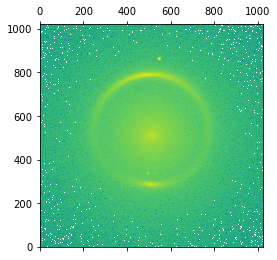

x_image[0]: 0.13158224205069302 y_image[0]: 1.3637534342595852
x_image[1]: -0.06653063343731988 y_image[1]: -0.6821237174335931
mag[0]: 1.6173968832173597 mag[1]: 0.31402162822682045
1


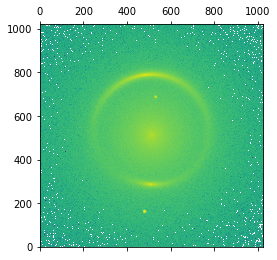

x_image[0]: -0.13205485916616033 y_image[0]: -1.3637075302621702
x_image[1]: 0.06670258385714857 y_image[1]: 0.6821069009413212
mag[0]: 1.6173980914824317 mag[1]: 0.3140215260381151
1


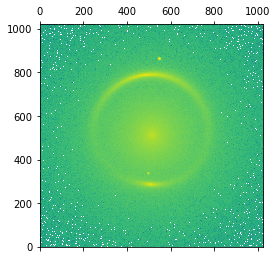

x_image[0]: 0.13248449998521025 y_image[0]: 1.363665675194379
x_image[1]: -0.06685889909615231 y_image[1]: -0.682091577513793
mag[0]: 1.6173990900535102 mag[1]: 0.31402144158368855
1


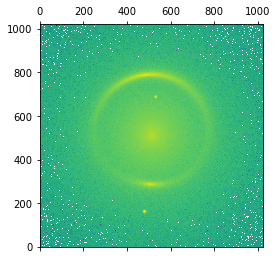

x_image[0]: -0.13287507326944364 y_image[0]: -1.3636275225295118
x_image[1]: 0.06700100109212505 y_image[1]: 0.6820776176169152
mag[0]: 1.6173999153220737 mag[1]: 0.31402137178609857
1


In [19]:
for i in range(15):
    ra_source, dec_source = x_image[index],y_image[index] #putting the source at the caustic
    lensEquationSolver = LensEquationSolver(lens_model_class)
    x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                          min_distance=deltaPix, search_window=numPix * deltaPix)
    # compute lensing magnification at image positions
    mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
    mag = np.abs(mag)  # ignore the sign of the magnification

    # perturb observed magnification due to e.g. micro-lensing
    mag_pert = np.random.normal(mag, 0.5, len(mag))
    point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
    kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                               'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

    # note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
    # you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
    point_source_list = ['LENSED_POSITION']
    point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                    lens_light_model_class,
                                    point_source_class, kwargs_numerics=kwargs_numerics)
    image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
    poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
    bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
    image_sim = image_sim + bkg + poisson

    kwargs_data['image_data'] = image_sim
    data_class.update_data(image_sim)

    plt.matshow(np.log10(image_sim), origin='lower')

    plt.show()
    print("x_image[0]:",x_image[0],"y_image[0]:",y_image[0])
    print("x_image[1]:",x_image[1],"y_image[1]:",y_image[1])
    print("mag[0]:",mag[0],"mag[1]:",mag[1])
    caustic_finder(mag[0],mag[1])